# Project requirements and tips


## Setup

Download the dataset from the [iris kaggle competition](https://www.kaggle.com/uciml/iris).
Place the *csv* file it in a directory called *data* with the name *Iris.csv*.

## Libraries

If `install.sh` ran successfully, you should have all the required libraries:

* `numpy` - Library for fast C++ arrays/matrix and operations on those.
* `pandas` - Library for loading & processing & writing csv/json/etc. as matrixes.
* `scikit-learn` - Library for machine learning algorithms. Mostly compatible with numpy & pandas.
* `matplotlib` - Library for plots.
* `seaborn` - Library for high level plots that uses `matplotlib` under the hood.


# Data Science Walkthrough - Tips&Tricks

# Data preprocessing

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Conversion of categorical columns to numerical columns

In [51]:
initial_data = pd.DataFrame({
    'speed': [20, 35, 40, 90, 50, 80],
    'height': [0.3, 0.4, 0.6, 1.2, 0.5, 1.4],
    'animal': ['cat', 'cat', 'dog', 'lion', 'dog', 'lion'],
    'quality': ['Poor', 'Average', 'Good', 'Good', 'Poor', 'Average']
})
data = initial_data.copy(deep=True)
data

,speed,height,animal,quality
0,20,0.3,cat,Poor
1,35,0.4,cat,Average
2,40,0.6,dog,Good
3,90,1.2,lion,Good
4,50,0.5,dog,Poor
5,80,1.4,lion,Average


### Method I: HashEncoding - Recommended for ordered categories

Assign a different number for each category starting from 0. Used for columns with categories that can be ordered (in this example for the `quality` column) and for the label.

To implement this use:

* [For columns](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder)
* [For labels](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)


In [59]:
data['quality'] = [0, 1, 2, 2, 0, 1]
data

,speed,height,animal,quality
0,20,0.3,cat,0
1,35,0.4,cat,1
2,40,0.6,dog,2
3,90,1.2,lion,2
4,50,0.5,dog,0
5,80,1.4,lion,1


### Method II: OneHotEncoding - Recommended for any other type of columns

For each category create a new boolean column. Instances that have that categority will have a value of 1 (True) and 0 (False) otherwise.

To implement this use:
* [Using pandas](http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example)
* [Using scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)


In [60]:
data['is_cat']  = [1, 1, 0, 0, 0, 0]
data['is_dog']  = [0, 0, 1, 0, 1, 0]
data['is_lion'] = [0, 0, 0, 1, 0, 1]
data.drop(columns=['animal'], inplace=True)
data

,speed,height,quality,is_cat,is_dog,is_lion
0,20,0.3,0,1,0,0
1,35,0.4,1,1,0,0
2,40,0.6,2,0,1,0
3,90,1.2,2,0,0,1
4,50,0.5,0,0,1,0
5,80,1.4,1,0,0,1


## Normalization of columns

Usually, different columns use different methods of measurements, different units and have different intervals for their values (in the example, speed between 0-300 and height between 0-2) as they represent different things (speed vs height). By data normalization, this differences will more or less not be as relevant as they will be converted to the same ranges.

### Method I: Standard Scaler

Because columns usually have different means and standard deviations, it is desired to *standardize* them by making the mean 0 and the standard deviation 1, as some classifiers behave badly if this is not enforced.

For each value, substract the mean and divide by the standard deviation:`
* $x_{new} = \frac{x\ -\ E[X]}{\sigma[X]}$

Using *standardization*, the new value will represent how far the value is from the mean. As such, the columns will have more or less the same meaning, how distant is that value from the the average.

To standardize the data, use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) offered by `scikit-learn`.

In [170]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pipeline = Pipeline([
    (
        'scaler',
        ColumnTransformer([
            ('StandardScaler', scaler, ['speed', 'height'])
        ], remainder='passthrough')
    )
])
pipeline.fit(data)
pd.concat([
    data[['speed', 'height']].rename({'speed': 'old_speed', 'height': 'old_height'}, axis=1),
    pd.DataFrame(pipeline.transform(data), columns=data.columns)
], axis=1)

,old_speed,old_height,speed,height,quality,is_cat,is_dog,is_lion
0,20,0.3,-1.310971,-1.044185,0.0,1.0,0.0,0.0
1,35,0.4,-0.705907,-0.803219,1.0,1.0,0.0,0.0
2,40,0.6,-0.504219,-0.321288,2.0,0.0,1.0,0.0
3,90,1.2,1.512658,1.124507,2.0,0.0,0.0,1.0
4,50,0.5,-0.100844,-0.562254,0.0,0.0,1.0,0.0
5,80,1.4,1.109283,1.606439,1.0,0.0,0.0,1.0


### Method II: RobustScaler

If your data contains many outliers, scaling using the mean and variance of the data is likely to not work very well as they might get affected by the anomalies. To scale this kind of data, we first have to remove the outliers using statistical methods and the apply *standardization*.

This is where [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler) comes into play. If first removes the outliers using the [IQR](https://en.wikipedia.org/wiki/Interquartile_range) method and then applies standardization:

* Find the 25% percentile (the median of the first half of the numbers - $Q1$) and the 75% percetile (the median of the second half - $Q3$).
* Compute the *Interquartile range*: $IRQ = Q3 - Q1$
* Remove any number that satisfies either one of the:
  * $x < Q1 - 1.5 * IRQ$
  * $x > Q3 + 1.5 * IRQ$
* Compute the standardization using the mean and standard deviation of the remaining values:
  * $x_{new} = \frac{x\ -\ E[X_{remaining}]}{\sigma[X_{remaining}]}$

In [169]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
pipeline = Pipeline([
    (
        'scaler',
        ColumnTransformer([
            ('StandardScaler', scaler, ['speed', 'height'])
        ], remainder='passthrough')
    )
])
pipeline.fit(data)
pd.concat([
    data[['speed', 'height']].rename({'speed': 'old_speed', 'height': 'old_height'}, axis=1),
    pd.DataFrame(pipeline.transform(data), columns=data.columns)
], axis=1)

,old_speed,old_height,speed,height,quality,is_cat,is_dog,is_lion
0,20,0.3,-0.689655,-0.40,0.0,1.0,0.0,0.0
1,35,0.4,-0.275862,-0.24,1.0,1.0,0.0,0.0
2,40,0.6,-0.137931,0.08,2.0,0.0,1.0,0.0
3,90,1.2,1.241379,1.04,2.0,0.0,0.0,1.0
4,50,0.5,0.137931,-0.08,0.0,0.0,1.0,0.0
5,80,1.4,0.965517,1.36,1.0,0.0,0.0,1.0


### Method III: MinMax Scaler

An alternative to *standardization* is scaling features to lie between a given minimum and maximum value, often between 0 and 1.

For this, use the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) with interval (min, max). This uses the following formula:

* $x_{new} = min + (max - min) * \frac{x\ -\ \underset{x}{min}\ (X)}{\underset{x}{max}\ (X)\ -\ \underset{x}{min}\ (X)}$

In [171]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
pipeline = Pipeline([
    (
        'scaler',
        ColumnTransformer([
            ('StandardScaler', scaler, ['speed', 'height'])
        ], remainder='passthrough')
    )
])
pipeline.fit(data)
pd.concat([
    data[['speed', 'height']].rename({'speed': 'old_speed', 'height': 'old_height'}, axis=1),
    pd.DataFrame(pipeline.transform(data), columns=data.columns)
], axis=1)

,old_speed,old_height,speed,height,quality,is_cat,is_dog,is_lion
0,20,0.3,0.000000,0.000000,0.0,1.0,0.0,0.0
1,35,0.4,0.214286,0.090909,1.0,1.0,0.0,0.0
2,40,0.6,0.285714,0.272727,2.0,0.0,1.0,0.0
3,90,1.2,1.000000,0.818182,2.0,0.0,0.0,1.0
4,50,0.5,0.428571,0.181818,0.0,0.0,1.0,0.0
5,80,1.4,0.857143,1.000000,1.0,0.0,0.0,1.0


### Method IV: MaxAbs Scaler

Another simpler alternative is just ensuring that the maximum absolute value of the new column is 1. This way, the new inverval for the values will range at most between -1 and 1.

For this, use the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler). This uses the following formula:

* $x_{new} = \frac{x}{\underset{x}{max}\ (|X|)}$

In [168]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
pipeline = Pipeline([
    (
        'scaler',
        ColumnTransformer([
            ('StandardScaler', scaler, ['speed', 'height'])
        ], remainder='passthrough')
    )
])
pipeline.fit(data)
pd.concat([
    data[['speed', 'height']].rename({'speed': 'old_speed', 'height': 'old_height'}, axis=1),
    pd.DataFrame(pipeline.transform(data), columns=data.columns)
], axis=1)

,old_speed,old_height,speed,height,quality,is_cat,is_dog,is_lion
0,20,0.3,0.222222,0.214286,0.0,1.0,0.0,0.0
1,35,0.4,0.388889,0.285714,1.0,1.0,0.0,0.0
2,40,0.6,0.444444,0.428571,2.0,0.0,1.0,0.0
3,90,1.2,1.000000,0.857143,2.0,0.0,0.0,1.0
4,50,0.5,0.555556,0.357143,0.0,0.0,1.0,0.0
5,80,1.4,0.888889,1.000000,1.0,0.0,0.0,1.0


## Feature creation / selection

Sometimes, the features that are present are not enought to for a classifier to use or are two many and wish to have less features. In this case, new features are created by multiplying, dividing squaring and even using random formulas to combine features and form new ones to add to the dataset or in place of the existing ones. Sometimes if a feature is not relevant it is removed entirely.

### Method I: Simple division / substraction / addition

In some cases, a new feature can be created by dividing (or adding / substracting) two columns. There is no special class or method here for this, you can simply use [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.divide.html).

In [68]:
new_data = data.copy(deep=True)
new_data['speed / height'] = data['speed'] / data['height']
new_data

,speed,height,quality,is_cat,is_dog,is_lion,speed / height
0,20,0.3,0,1,0,0,66.666667
1,35,0.4,1,1,0,0,87.500000
2,40,0.6,2,0,1,0,66.666667
3,90,1.2,2,0,0,1,75.000000
4,50,0.5,0,0,1,0,100.000000
5,80,1.4,1,0,0,1,57.142857


### Method II: Polynomial Transform

Simple classifiers like decision trees can be too simple in some cases. One solution that can work is to create new more complex features from the existing ones either by squaring them (or even using the n-th power) or multiply them two by two.

To do this, use the [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) from the `scikit-learn` library.

In [100]:
from sklearn.preprocessing import PolynomialFeatures
import re

def get_original_feature(column_name, original_columns):
    variables_ids = re.findall('x([0-9]+)', column_name)
    if variables_ids:
        for variable_id in variables_ids:
            col_no = int(variable_id)

            column_name = re.sub('x' + variable_id, original_columns[col_no], column_name)
    return column_name

transformer = PolynomialFeatures(include_bias=False).fit(data)
pd.DataFrame(transformer.transform(data), columns=[get_original_feature(col, data.columns) for col in transformer.get_feature_names()])

,speed,height,quality,is_cat,is_dog,is_lion,speed^2,speed height,speed quality,speed is_cat,...,quality^2,quality is_cat,quality is_dog,quality is_lion,is_cat^2,is_cat is_dog,is_cat is_lion,is_dog^2,is_dog is_lion,is_lion^2
0,20.0,0.3,0.0,1.0,0.0,0.0,400.0,6.0,0.0,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35.0,0.4,1.0,1.0,0.0,0.0,1225.0,14.0,35.0,35.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,40.0,0.6,2.0,0.0,1.0,0.0,1600.0,24.0,80.0,0.0,...,4.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,90.0,1.2,2.0,0.0,0.0,1.0,8100.0,108.0,180.0,0.0,...,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
4,50.0,0.5,0.0,0.0,1.0,0.0,2500.0,25.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,80.0,1.4,1.0,0.0,0.0,1.0,6400.0,112.0,80.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Method III: Log/Exp Transform - Function Transformer

Another method to create new features is by using some function to transform the data. Commonplace is to use the natural logarithm - $x_{new} = log(1 + x)$ for positive values or exponentiation $x_{new} = e^{x}$.

This is achieved using the [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) and with the [log1p](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html) or [exp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html) functions.


In [111]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

columns_to_transform = ['speed', 'height']

transformer = FunctionTransformer(np.log1p, validate=True).fit(data[columns_to_transform])

pd.concat([
    data,
    pd.DataFrame(
       transformer.transform(data[columns_to_transform]),
       columns=['log_' + col for col in columns_to_transform]
    )
], axis=1)

,speed,height,quality,is_cat,is_dog,is_lion,log_speed,log_height
0,20,0.3,0,1,0,0,3.044522,0.262364
1,35,0.4,1,1,0,0,3.583519,0.336472
2,40,0.6,2,0,1,0,3.713572,0.470004
3,90,1.2,2,0,0,1,4.510860,0.788457
4,50,0.5,0,0,1,0,3.931826,0.405465
5,80,1.4,1,0,0,1,4.394449,0.875469


### Method IV: Dimensionality reduction

For some datasets, dimensionality reduction is a good way to create new features that are a linear/non-linear combination of the old featutures to be used instead, thus reducing the number of features. This is also good for data visualization.

[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) is such an algorithm. Remember the covariance of two random variables. If their covariance is 0, then the variables can be considered statisticaly independent of each other. If we manage to transform our data in such a way that each column is independent of the others, then we can successfully eliminate the *redundancy* of the data.


Let $\Sigma_X = XX^T$. On it's diagonal there are the variances of each of the columns. The rest of the values are the pairwise covariances of the columns. You can notice that this matrix is symetrical (self-adjoint, hermitian). If we apply a decomposition called [SVD decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) on this matrix, we will obtain a orthogonal matrix $S$ $(SS^T = S^TS = I_n)$ and a diagonal matrix $\Lambda$ such that $\Sigma_X = S\Lambda S^T$. Now let $Y = S^T X$. The covariance matrix of $Y$ is:

$\Sigma_Y = YY^T = (S^TX)(S^TX)^T = S^TXX^TS = (S^T\Sigma_X S) = S^TS\Lambda S^TS = I_n \Lambda I_n = \Lambda$ which is a diagonal matrix, covariance 0. As such, Y is the new representation of the data. Furthemore, the columns of $Y$ will be sorted by importance. As such, only some of the first columns can be used as the new dataset or only the first 2 columns for data vizualization.

In [133]:
from sklearn.decomposition import PCA
import numpy as np

transformer = PCA(n_components=2).fit(data)
pca_data = transformer.transform(data)

pd.concat([
    data,
    pd.DataFrame(
       pca_data,
       columns=['pca_feature' + str(idx) for idx in range(1, pca_data.shape[1] + 1)]
    )
], axis=1)

,speed,height,quality,is_cat,is_dog,is_lion,pca_feature1,pca_feature2
0,20,0.3,0,1,0,0,-32.520019,-0.601164
1,35,0.4,1,1,0,0,-17.509843,0.123310
2,40,0.6,2,0,1,0,-12.483491,1.374534
3,90,1.2,2,0,0,1,37.522051,0.308370
4,50,0.5,0,0,1,0,-2.522732,-0.710906
5,80,1.4,1,0,0,1,27.514034,-0.494142


## Data Visualization

Let's say we want to have insight about the data or present them to our coworkers or audience. The common method for by showing plots of the data.

In [177]:
import matplotlib.pyplot as plt
import seaborn as sbn

### Method I: Histogram/Distribution plot

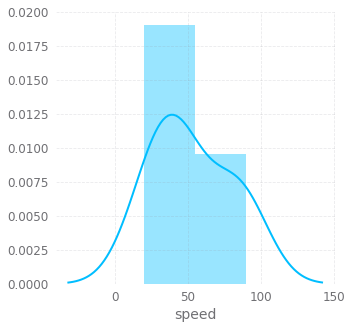

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sbn.distplot(data['speed'], ax=ax)

### Method II: Boxplot

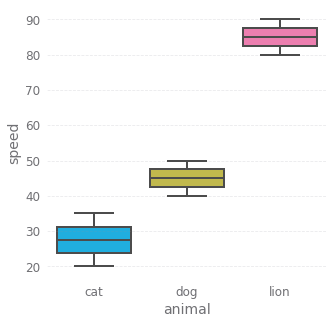

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sbn.boxplot(x=initial_data['animal'], y=data['speed'], ax=ax)

### Method III: Scatter plot

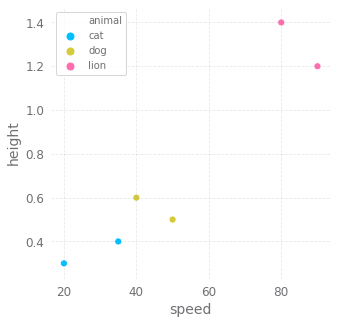

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sbn.scatterplot(x=data['speed'], y=data['height'], hue=initial_data['animal'], ax=ax)

### Method IV: Line plot

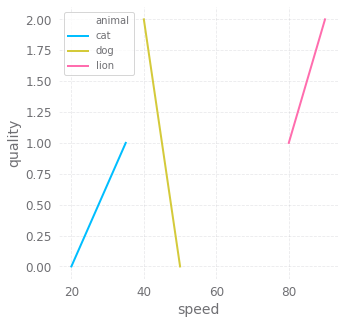

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sbn.lineplot(x=data['speed'], y=data['quality'], hue=initial_data['animal'], ax=ax)

### Method V: Dimensionality reduction scatter plot

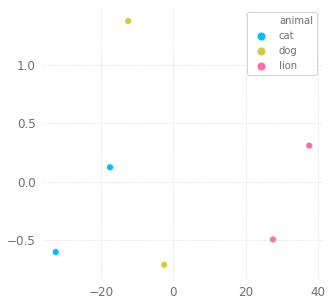

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sbn.scatterplot(pca_data[:, 0], pca_data[:, 1], hue=initial_data['animal'], ax=ax)

# Project requirements

* At least two methods for data vizualization
* At least one method for preprocessing
* At least one clustering algorithm
* At least one metric function for the clustering
* At least one vizualization of the clustering results using dimensionality reduction or a scatterplot or decision boundaries.
* Split the data into a train / test set. Make sure to only train on the train set. Test only on the test set.
* Further split the train set into a train and validation set and use the validation set or use K-Fold cross validation to find the optimal hyperparameters for the algorithm.
* At least two classification algorithms
* At least two metric functions for the classification
* At least one vizualization of the classification results using dimensionality reduction for a scatterplot or decision boundaries.
* Comparisons between the results of the two classifiers (using the choosen metrics and any other observsations)

## Algorithms Requirements

### Gaussian Naive Bayes

Make sure to use the [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB).

Requirements:
* Show the results of the metrics on the train set (this should be high) and very important, on the test set (this should be more realistic)
* Plot the importance of each feature (there is a method that fetches the feature importance)
* For each label and feature plot the gaussian distributions.

Tips:
* Categorical columns do not need preprocessing
* Try both with/without scaling
* Try to put ordered values in bins if it makes sense to do so

### Decision Trees

Make sure to use the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

#### Requirements:
* Vizualize the full / partial tree
  * Make sure that the nodes are vizible (plot a smaller tree if the full tree is to big)
  * Make sure it's vizible
* Plot the metric when some of the hyperparameters of the algorithm are increased / decreased to have a general idea of what happens
* Show the results of the metrics on the train set (this should be high) and very important, on the test set (this should be more realistic)
* Plot the importance of each feature (there is a method that fetches the feature importance)

#### Tips:
* Big trees can fail hard. Make sure to have some prunning.

### AdaBoost

Make sure to use the [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).


#### Requirements:
* Use only DecisionTrees of size of max 3
* Plot the values for the alphas
* Plot the metric when some of the hyperparameters of the algorithm (or the base classifier) are increased / decreased to have a general idea of what happens
* Show the results of the metrics on the train set (this should be high) and very important, on the test set (this should be more realistic)
* Plot the importance of each feature (there is a method that fetches the feature importance)
* Plot the best classifiers (the ones with the greatest absolute alpha)

#### Tips:
* Too many classifiers can lead to overfit and too little to underfit. Make sure to set realistic number. Try multiple variants.

### K-NN

Make sure to use the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

#### Requirements:
* Plot the metric when `K` is increased / decreased
* Plot the metric when some of the other hyperparameters of the algorithm are increased / decreased to have a general idea of what happens
* Show the results of the metrics on the train set (this should be high) and very important, on the test set (this should be more realistic)
* Also try K-NN after dimensionality reduction is applied
* Plot decision boundaries for 1-NN on a 2 component PCA

#### Tips:
* Make sure you normalize the data as the algorithm if very sensible. The bigger the values for a column the more importance that column will have. As such all columns should be in the same range.

### KMeans

Make sure to use the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

#### Requirements:
* Plot the metric when `K` is increased / decreased
* Plot the metric when some of the other hyperparameters of the algorithm are increased / decreased to have a general idea of what happens
* Show the centroids values (for images show the image of the centroid)

#### Tips:
* Make sure you normalize the data as the algorithm if very sensible. The bigger the values for a column the more importance that column will have. As such all columns should be in the same range.

### Hierarhical Clustering

Make sure to use the [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering).

#### Requirements:
* Plot the dendrogram (or at least the top part) and explain how the cutoff happened and where.
* Plot the metric when some of the other hyperparameters of the algorithm are increased / decreased to have a general idea of what happens

#### Tips:
* Make sure you normalize the data as the algorithm if very sensible. The bigger the values for a column the more importance that column will have. As such all columns should be in the same range.

### EM

Make sure to use the [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).

#### Requirements:
* Plot the metric when `K` is increased / decreased
* Plot the metric when some of the other hyperparameters of the algorithm are increased / decreased to have a general idea of what happens

#### Tips:
* Make sure you normalize the data as the algorithm if very sensible. The bigger the values for a column the more importance that column will have. As such all columns should be in the same range.